In [77]:
# csce478    Final Project: Stock prediction          Fall 2020                       Due: Nov 19  11am
# contributers: Chungsu Kim, Devan Steiner, Jesse Reyes Cortes

# simple explanation


# all imported libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
import pydotplus
from io import StringIO 
from sklearn.decomposition import PCA




# helper functions
def accuracy(x,y):
    count = 0
    for i in range(0, len(x)):
        if(x[i]==1 and .5 < y[i]):
            count = count + 1
        elif(x[i]==0 and y[i] < .5):
            count = count + 1
    
    return count/len(x)




def partition(X, Y, t):     
    test_size = math.ceil(len(Y)*t)
    training_size = len(Y)-test_size
    training_data = X[0:training_size][:]
    testing_data = X[training_size+1:len(Y)] [:]
    training_vector = Y[0:training_size]
    testing_vector = Y[training_size+1:len(Y)]
    
    return training_data, testing_data, training_vector, testing_vector




def kFoldHelper(X,Y, k):
    
    kData = []
    x = np.array_split(X,k)
    y = np.array_split(Y,k)
    
    for i in range(0, k):
        x_train = pd.DataFrame([])
        y_train = pd.DataFrame([])
        x_test = np.array(x[i])
        y_test = np.array(x[i])
        for j in range(0,k):
            if i != j:
                x_train = x_train.append(pd.DataFrame(x[j]))
                y_train = y_train.append(pd.DataFrame(y[j]))

        kData.append([np.array(x_train),np.squeeze(np.array(y_train)),x_test,y_test])
    
    return kData




In [3]:
# read in fake news data set
data = pd.read_csv("news-dataset.csv", delimiter=',')
data = data[data["URLs"].notna()]
data = data[data["Headline"].notna()]
data = data[data["Body"].notna()]
data = data[data["Label"].notna()]
data.reset_index(inplace=True)

# # extract data
X = pd.DataFrame([])
X["URLs"] = data["URLs"]
X["Headline"] = data["Headline"]
X["Body"] = data["Body"]

Y = data["Label"]

data.describe(include='all')


,index,URLs,Headline,Body,Label
count,3988.000000,3988,3988,3988,3988.000000
unique,NaN,3332,2823,2863,NaN
top,NaN,http://beforeitsnews.com/sports/2017/09/930-tr...,2017 Fantasy Football Quarterback Rankings - W...,A Potato Battery Can Light up a Room for Over ...,NaN
freq,NaN,5,6,143,NaN
mean,2005.714644,NaN,NaN,NaN,0.468405
std,1157.218870,NaN,NaN,NaN,0.499063
min,0.000000,NaN,NaN,NaN,0.000000
25%,1004.750000,NaN,NaN,NaN,0.000000
50%,2006.500000,NaN,NaN,NaN,0.000000
75%,3007.250000,NaN,NaN,NaN,1.000000


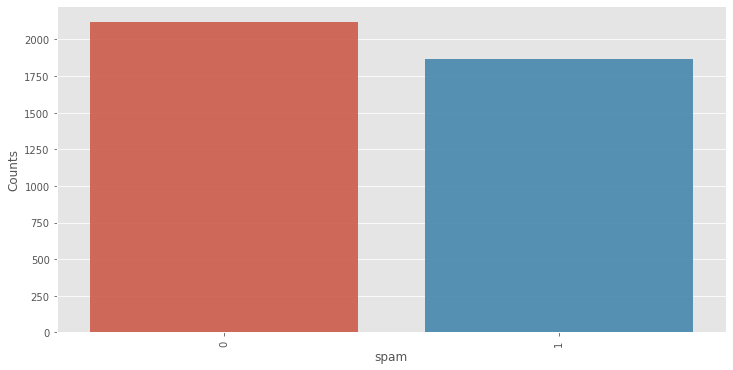

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

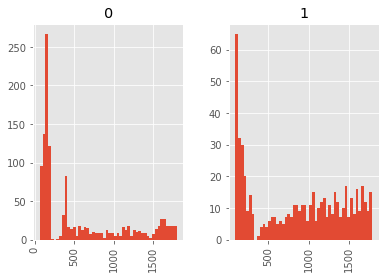

In [3]:
# visualization of training data

label_counts = Y.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()
# get column "length" the stores the length of the body of each article
data["length"] = data["Body"].map(lambda text: len(text))

data.groupby('Label').length.describe()
articles_subset = data[data.length < 1800]
articles_subset.hist(column='length', by='Label', bins=50)

In [4]:
# text preprocessing


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

X_lem = X.Body.map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

X_stem = X.Body.map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text.lower())))


# remove stop words & convert to numerical feature vectors

cv = CountVectorizer(lowercase=True, stop_words='english')
X_lem = cv.fit_transform(X_lem)

cv2 = CountVectorizer(lowercase=True, stop_words='english')
X_stem = cv2.fit_transform(X_stem)

X_lem = X_lem.toarray()
X_stem = X_stem.toarray()

In [76]:
# train

# multinomial naive bayes classifier ; assignment 3 part A
class Multinomial_NB:
    def __init__(self, alpha=1.0):
        self.X = np.array([])
        self.Y = np.array([])
        self.alpha = alpha
        self.prior_h = 0
        self.prior_s = 0
        self.h_total = 0
        self.s_total = 0
        self.feature_h = []
        self.feature_s = []
        
    def fit(self, X, Y, **kwargs):
        self.X = X
        self.Y = Y
        
        # save feature counts for spam & ham
        self.feature_h = np.zeros(( len(self.X[0])))
        self.feature_s = np.zeros(( len(self.X[0])))
        
        if "alpha" in kwargs:
            self.alpha = kwargs["alpha"]
        
        h_count = 0
        s_count = 0
        
        for i in range(0, len(self.X)):
            
            # count total for real & fake
            # real news
            if(self.Y[i]==1):
                self.feature_s = np.add(self.feature_s, self.X[i])
                s_count = s_count + 1
            # fake news
            else:
                self.feature_h = np.add(self.feature_h, self.X[i])
                h_count = h_count + 1
                
        self.s_total = sum(self.feature_s)
        self.h_total = sum(self.feature_h)
                
         
        self.prior_h = (self.alpha + h_count)/(2*self.alpha + (h_count + s_count))
        self.prior_s = (self.alpha + s_count)/(2*self.alpha + (h_count + s_count))

        
        
    def predict(self, X):
        
        predict = []
        
        log_post = self.predict_log_proba(X)
        
        for i in range(0, len(X)):
         
            prob_s = math.log(self.prior_s) + log_post[i][0]
            prob_h = math.log(self.prior_h) + log_post[i][1]
                
            if(prob_s > prob_h):
                predict.append(1)
            else:
                predict.append(0)
                
        return predict
    
    
    
    def predict_log_proba(self, X):
        
        log_post = np.zeros((len(X),2))
        
        for i in range(0, len(X)):
            
            #predicting spam
            post_s = 0
            #predicting ham
            post_h = 0
            
            for j in range(0, len(X[i])):
                p_s = self.alpha + self.feature_s[j]
                p_h = self.alpha + self.feature_h[j]
                    
                post_s = post_s + (self.X[i][j] * math.log(p_s/(2*self.alpha + self.s_total)))
                post_h = post_h + (self.X[i][j] * math.log(p_h/(2*self.alpha + self.h_total)))
            
            log_post[i][0] = post_s
            log_post[i][1] = post_h
                
        return log_post

    
    
# initialize model
model = Multinomial_NB()

# hyper parameters
alpha = [0.0000001,0.000001,0.0001, 0.001, 0.01, 0.5, 1.0, 1.5, 2.0] 
data = [X_lem, X_stem]

count = 0

# running model on hyper parameters
for x in data:
    
    if count == 0:
        print("Lemmatized data:")
    else:
        print("Stemmatized data:")
        
    for a in alpha:
        
        # split data set to gathering training data
        x_train ,x_test, y_train, y_test = partition(x, Y, .20) 
        # train model
        model.fit(x_train, y_train, alpha=a)
        
        # predict labels
        y_hat = model.predict(x_test)
        
        print("alpha: ", a, "\tAccuracy: ", accuracy(np.array(y_test),y_hat))
    
    # update count
    count = 1

Lemmatized data:
alpha:  1e-07 	Accuracy:  0.5043914680050188


KeyboardInterrupt: 

In [32]:
# comparison to sklearn
model = MultinomialNB()

# lem data
x_train ,x_test, y_train, y_test = partition(X_lem, Y, .20) 
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
print("Multinomial NB Sklearn accuracy(lem): ", accuracy(np.array(y_test), y_hat), "\n")

# stem data
x_train ,x_test, y_train, y_test = partition(X_stem, Y, .20) 
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
print("Multinomial NB Sklearn accuracy(stem): ", accuracy(np.array(y_test), y_hat))


Multinomial NB Sklearn accuracy(lem):  0.9774153074027604 

Multinomial NB Sklearn accuracy(stem):  0.973651191969887


In [41]:
# decision tree classifier
model = DecisionTreeClassifier(criterion="entropy")

# lem data
x_train ,x_test, y_train, y_test = partition(X_lem, Y, .20) 
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
print("Decision Tree Classifer Sklearn accuracy(lem): ", accuracy(np.array(y_test), y_hat), "\n")

# stem data
x_train ,x_test, y_train, y_test = partition(X_stem, Y, .20) 
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
print("Decision Tree Classifer Sklearn accuracy(stem): ", accuracy(np.array(y_test), y_hat))

Decision Tree Classifer Sklearn accuracy(lem):  0.9560853199498118 

Decision Tree Classifer Sklearn accuracy(stem):  0.9648682559598495


3988
3988


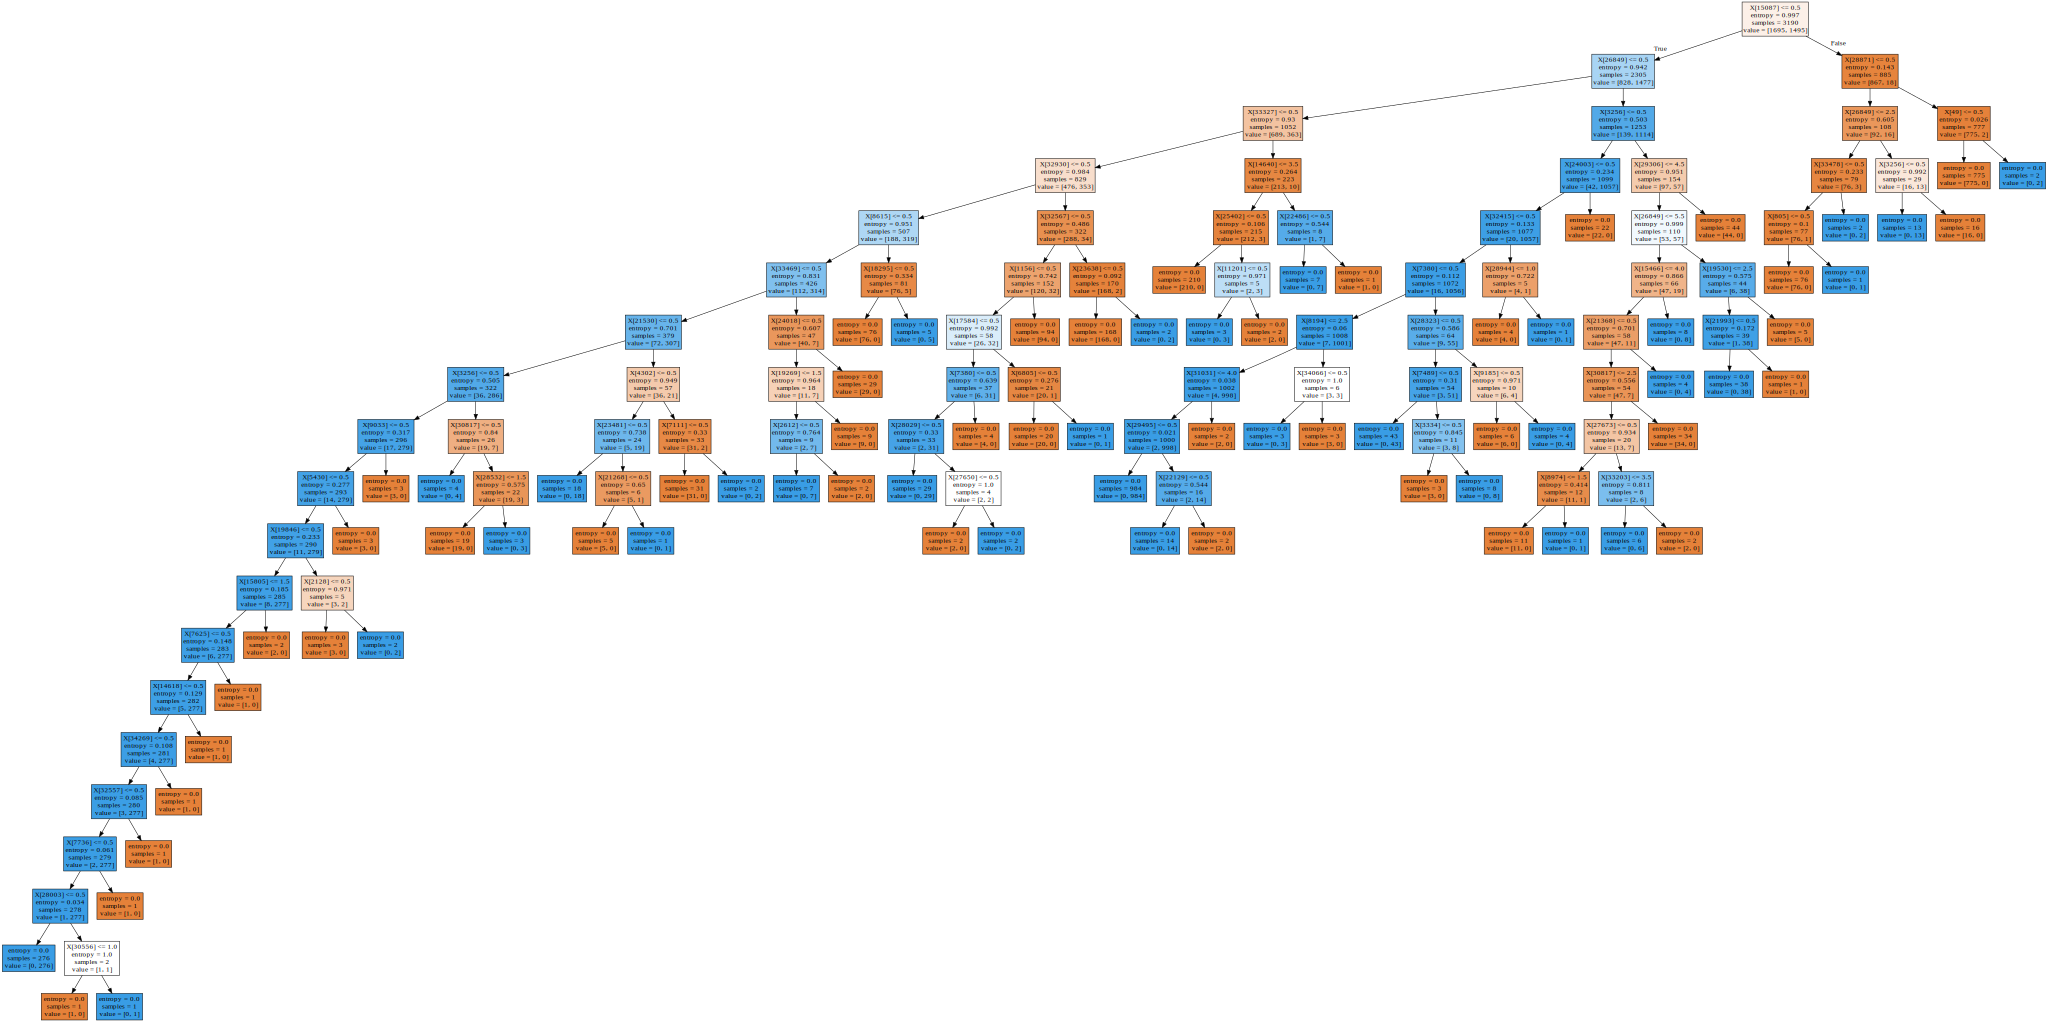

In [75]:
print(len(X_lem))
print(len(Y))
# DOT data
dot_data = tree.export_graphviz(model, out_file=None, 
                                filled=True)

# export graph
grap=pydotplus.graph_from_dot_data(dotfile.getvalue())
grap.write_png("dtree.png")

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render()
graph



In [80]:
# pca on data to reduce to 2 features
model = PCA(n_components=2)
pca_x_lem = model.fit_transform(X_lem)

In [84]:
# test real world samples
print(len(pca_x_lem))
print(len(Y))

3988
3988


In [ ]:
# results of real world samples
